In [3]:
'''
Training Data is a N*T*n tensor, N is the number of samples, T is the interval,
n is number of neurons.
Training Data is a N*1*1 tensor, N is the number of samples, 1*1 represents the
output dimension, which is the position of last time point.
Testing Data is a N'*T*n tensor.
Testing label is a N*1*1 tensor.
E.g.,
TrainingData = create_subsequences(np.transpose(X, TimeInterval))
TrainingLabel = Y[TimeInterval-1:].reshape(-1,1)
X is dFF, Y is corresponding position.
'''

"\nTraining Data is a N*T*n tensor, N is the number of samples, T is the interval,\nn is number of neurons.\nTraining Data is a N*1*1 tensor, N is the number of samples, 1*1 represents the\noutput dimension, which is the position of last time point.\nTesting Data is a N'*T*n tensor.\nTesting label is a N*1*1 tensor.\nE.g.,\nTrainingData = create_subsequences(np.transpose(X, TimeInterval))\nTrainingLabel = Y[TimeInterval-1:].reshape(-1,1)\nX is dFF, Y is corresponding position.\n"

In [1]:
import torch, os, glob
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)
import scipy, pandas as pd, random
from sklearn.preprocessing import MinMaxScaler

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim = 256, output_dim = 1, 
        num_layers = 2):
        # hidden_dim = height of network
        # layers = weight of network
        super(LSTMModel, self).__init__()
        # Initialize the LSTM, Hidden Layer, and Output Layer
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                dropout = 0.0, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        
        return out

def create_subsequences(time_series, subsequence_length=20):
    num_subsequences = len(time_series) - subsequence_length + 1
    subsequences = [time_series[i:i+subsequence_length] for i in range(num_subsequences)]
    return np.array(subsequences)

class CreateTimeSeriesData(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [2]:
# import raw data
with open("Z:\dcts_com_opto_inference.p", "rb") as fp: #unpickle
        dcts = pickle.load(fp)
conddf = pd.read_csv(r"Z:\condition_df\conddf_neural_com_inference.csv", index_col=None)
# day
dd=17

In [3]:
# make models for all animals/days
for dd in range(len(conddf)): #
    if True: #conddf.in_type.values[dd]=='vip':
        animal = conddf.animals.values[dd]
        day = conddf.days.values[dd]
        savepth = rf'Z:\models_lstm_inactive'   
        testpth = glob.glob(os.path.join(savepth, f'model_dd{dd:02d}*_{animal}_day{day}*'), recursive=True)
        if len(testpth)==0:             
            dct = dcts[dd]
            day=conddf.days.values[dd]
            animal = conddf.animals.values[dd]
            params_pth = rf"Y:\analysis\fmats\{animal}\days\{animal}_day{day:03d}_plane0_Fall.mat"
            print(params_pth)
            fall = scipy.io.loadmat(params_pth, variable_names=['dFF', 'forwardvel', 'ybinned', 'iscell',
                                        'trialnum', 'bordercells', 'changeRewLoc', 'licks'])
            inactive = dcts[dd]['inactive']
            changeRewLoc = np.hstack(fall['changeRewLoc']) 
            eptest = conddf.optoep.values[dd]
            eps = np.where(changeRewLoc>0)[0]
            rewlocs = changeRewLoc[eps]
            eps = np.append(eps, len(changeRewLoc)) 
            if conddf.optoep.values[dd]<2: 
                eptest = random.randint(2,3)   
                if len(eps)<4: eptest = 2 # if no 3 epochs
            trialnum = np.hstack(fall['trialnum'])
            comp = [eptest-2,eptest-1] # eps to compare  
            other_ep = [xx for xx in range(len(eps)-1) if xx not in comp]
            # filter iscell
            dff = fall['dFF'][:,(fall['iscell'][:,0].astype(bool)) & (~fall['bordercells'][0].astype(bool))]
            dff = dff[:,dct['inactive']]
            # remove nans
            dff[:, sum(np.isnan(dff))>0] = 0
            dff_per_ep = [dff[eps[xx]:eps[xx+1]] for xx in range(len(eps)-1)]
            trialnum_per_ep = [trialnum[eps[xx]:eps[xx+1]] for xx in range(len(eps)-1)]
            # get a subset of trials
            dff_per_ep_trials = [dff_per_ep[ii][((trialnum_per_ep[ii]>2) & (trialnum_per_ep[ii]<=10)) | (trialnum_per_ep[ii]>15)] for ii in range(len(eps)-1)]
            dff_per_ep_trials_test = [dff_per_ep[ii][(trialnum_per_ep[ii]>10) & (trialnum_per_ep[ii]<16)] for ii in range(len(eps)-1)]
            position = fall['ybinned'][0]
            position_per_ep = [position[eps[xx]:eps[xx+1]] for xx in range(len(eps)-1)]
            # get a subset of trials
            position_per_ep_trials = [position_per_ep[ii][((trialnum_per_ep[ii]>2) & (trialnum_per_ep[ii]<=10)) | (trialnum_per_ep[ii]>15)] for ii in range(len(eps)-1)]
            position_per_ep_trials_test = [position_per_ep[ii][(trialnum_per_ep[ii]>10) & (trialnum_per_ep[ii]<16)] for ii in range(len(eps)-1)]
            # licks
            licks = fall['licks'][0]
            licks_per_ep = [licks[eps[xx]:eps[xx+1]] for xx in range(len(eps)-1)]
            # get a subset of trials
            licks_per_ep_trials = [licks_per_ep[ii][((trialnum_per_ep[ii]>2) & (trialnum_per_ep[ii]<=10)) | (trialnum_per_ep[ii]>15)] for ii in range(len(eps)-1)]
            licks_per_ep_trials_test = [licks_per_ep[ii][(trialnum_per_ep[ii]>10) & (trialnum_per_ep[ii]<16)] for ii in range(len(eps)-1)]
                #prepare variables 
            TimeInterval = 20 # frames
            train = dff_per_ep_trials[comp[0]]
            print(train.shape)
            if train.shape[1]>0:
                test = dff_per_ep_trials_test[comp[0]]
                # TODO: use a couple trials from same ep as testing
                # use different epochs for further testing
                train_pos = position_per_ep_trials[comp[0]]
                TrainingLabel = train_pos[TimeInterval-1:].reshape(-1,1)
                test_pos = position_per_ep_trials_test[comp[0]]
                TestLabel = test_pos[TimeInterval-1:].reshape(-1,1)

                TrainingData = create_subsequences(train,TimeInterval)
                batch_size = 128
                input_size = TrainingData.shape[-1] # number of cells
                output_size = 1

                Train_dataset = CreateTimeSeriesData(TrainingData, TrainingLabel)
                Train_loader = DataLoader(dataset=Train_dataset, batch_size=batch_size, 
                            shuffle=True, drop_last = True)
                TestData = create_subsequences(test,TimeInterval)
                Test_dataset = CreateTimeSeriesData(TestData, TestLabel)
                Test_loader = DataLoader(dataset=Test_dataset, batch_size=batch_size,
                            shuffle=False, drop_last = True)
                
                # define the model & train
                # TODO: add transfer learning
                model = LSTMModel(input_size, output_dim = output_size)
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                print(device)
                model = model.to(device)
                criterion = nn.MSELoss()  # For regression tasks
                # criterion = nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay = 1e-9)

                # Example training loop
                l = []
                val_l = []
                num_epochs = 3000
                    
                for epoch in range(num_epochs):
                    train_loss = 0.0
                    for inputs, targets in Train_loader:
                        # Forward pass
                        inputs, targets = inputs.to(device).float(), targets.to(device).float()
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)

                        # Backward pass and optimization
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        train_loss += loss.item()

                    l.append(train_loss/len(Train_loader))
                    if epoch % 20 == 0:
                        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss/len(Train_loader)))
                        val_loss = 0.0
                        for inputs, targets in Test_loader:
                            # Forward pass
                            inputs, targets = inputs.to(device).float(), targets.to(device).float()
                            outputs = model(inputs)
                            loss = criterion(outputs, targets)
                            val_loss += loss.item()
                            val_l.append(val_loss/len(Test_loader))
                        print('Validation Loss: {:.4f}'.format(val_loss/len(Test_loader)))
                # save        
                torch.save(model.state_dict(), os.path.join(savepth, f'model_dd{dd:03d}*_{animal}_day{day}_epcompare{comp[0]}-{comp[1]}.pt'))
            

Y:\analysis\fmats\e218\days\e218_day020_plane0_Fall.mat
(18732, 27)
cuda:0
Epoch [1/3000], Loss: 8414.4995
Validation Loss: 10771.5915
Epoch [21/3000], Loss: 6249.7454
Validation Loss: 8314.8667
Epoch [41/3000], Loss: 5475.1577
Validation Loss: 7416.3297
Epoch [61/3000], Loss: 4805.5725
Validation Loss: 6626.4357
Epoch [81/3000], Loss: 4243.4013
Validation Loss: 5942.4362
Epoch [101/3000], Loss: 3777.9807
Validation Loss: 5362.1007
Epoch [121/3000], Loss: 3414.1785
Validation Loss: 4878.6761
Epoch [141/3000], Loss: 3147.9212
Validation Loss: 4498.8983
Epoch [161/3000], Loss: 2955.5427
Validation Loss: 4217.1182
Epoch [181/3000], Loss: 2855.7898
Validation Loss: 4021.7466
Epoch [201/3000], Loss: 2728.5850
Validation Loss: 3868.4899
Epoch [221/3000], Loss: 2599.0624
Validation Loss: 3737.3037
Epoch [241/3000], Loss: 2133.5468
Validation Loss: 3415.7682
Epoch [261/3000], Loss: 1870.8603
Validation Loss: 3185.5338
Epoch [281/3000], Loss: 1749.2901
Validation Loss: 3163.4456
Epoch [301/3000

In [72]:
# load existing model
savepth = rf'Z:\\model_dd{dd}_conddct.pt'
print(dd)
model = LSTMModel(input_size, output_dim = output_size)
model.load_state_dict(torch.load(savepth))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
criterion = nn.MSELoss()  # For regression tasks
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, 
            weight_decay = 1e-9)

# use model to predict position
dff_test = dff_per_ep_trials_test[comp[1]]
# TODO: use a couple trials from same ep as testing
# use different epochs for further testing
pos = position_per_ep_trials_test[comp[1]]
pos = pos[TimeInterval-1:].reshape(-1,1)
lick = licks_per_ep_trials_test[comp[1]]

TestData = create_subsequences(dff_test,TimeInterval)
input_size = TestData.shape[-1] # number of cells
output_size = 1

Test_dataset = CreateTimeSeriesData(TestData, pos)
Test_loader = DataLoader(dataset=Test_dataset, batch_size=batch_size, 
                        shuffle=False, drop_last = True)
predict = []
val_loss = 0
for inputs, targets in Test_loader:
    # Forward pass
    inputs, targets = inputs.to(device).float(), targets.to(device).float()
    outputs = model(inputs)
    predict.append(outputs)
    loss = criterion(outputs, targets)
    val_loss += loss.item()
print('Validation Loss: {:.4f}'.format(val_loss/len(Test_loader)))

17
cuda:0
Validation Loss: 1451.2895


In [73]:
predict = np.concatenate([xx.cpu().detach().numpy() for xx in predict])

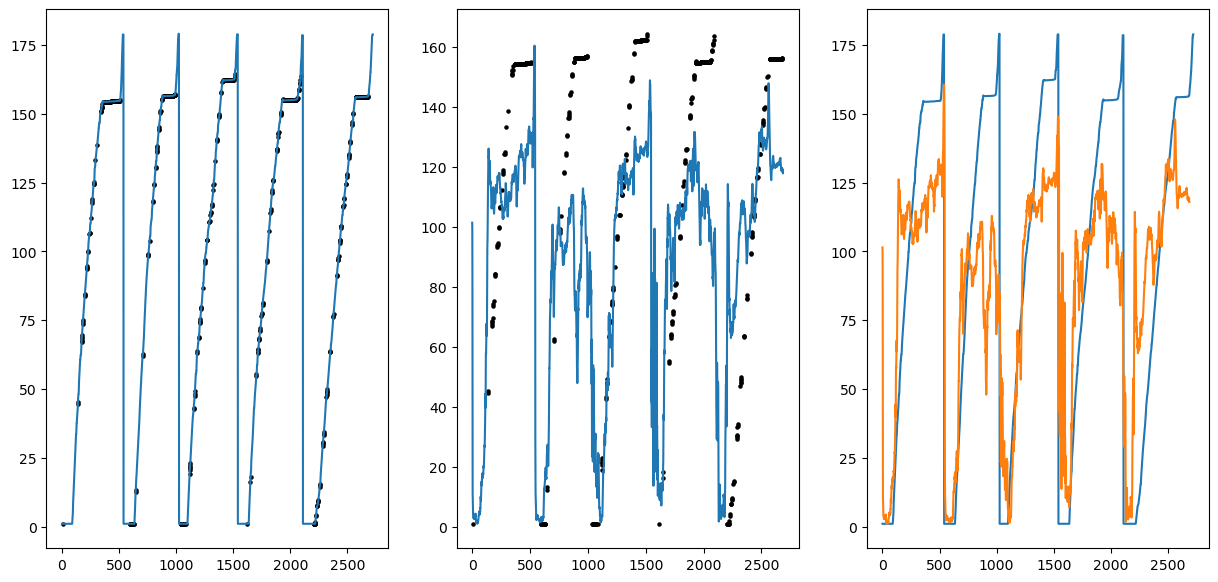

In [74]:
fig, axes = plt.subplots(1,3, figsize=(15,7))
axes[0].plot(pos)
axes[1].plot(predict)
axes[2].plot(pos)
axes[2].plot(predict)
axes[0].scatter(np.where(lick>0)[0], pos[np.where(lick>0)[0]], s=5, color='k')
axes[1].scatter(np.where(lick>0)[0], pos[np.where(lick>0)[0]], s=5, color='k')

In [75]:
print(pos.shape)
print(predict.shape)
# Compute the MAE and MSE on a test set
from sklearn.metrics import mean_absolute_error, mean_squared_error
if pos.shape[0]>predict.shape[0]:
    pos = pos[:predict.shape[0]]
mae = mean_absolute_error(pos, predict)
mse = mean_squared_error(pos, predict)
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}")


(2723, 1)
(2688, 1)
MAE: 29.9775, MSE: 1451.2895
